In [1]:
import glob
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import os.path as osp
import matplotlib.pyplot as plt

from model import models
from matplotlib.cm import Greens, Reds
from plottable import ColumnDefinition

from enums import PHASE
from configs import configs as dataset_configs
from data.set import GeneralDataset
from plottable import Table
from data.loader import collate_fns
from data.transforms import transforms
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from torch.utils.data import DataLoader
from torch.nn.functional import softmax
from plottable.formatters import decimal_to_percent


/home/vision/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utils

In [2]:
def remove_prefix_from_state_dict(original_state_dict, prefix_to_remove = 'resnet18.'):
    new_state_dict = {}
    # Iterate through the keys in the original state dictionary
    for key, value in original_state_dict.items():
        # Check if the key starts with the specified prefix
        if key.startswith(prefix_to_remove):
            # Create a new key without the prefix
            new_key = key[len(prefix_to_remove):]
            # Add the entry to the new state dictionary
            new_state_dict[new_key] = value
        else:
            # If the key doesn't start with the prefix, keep it unchanged
            new_state_dict[key] = value
    return new_state_dict

In [3]:
error = nn.CrossEntropyLoss(reduction='none')

In [4]:
def find_max_proba(prob_array):
    return np.max(prob_array)

In [5]:
def plot_mean_std(
    mean_std_wrong_labels_loss_df,
    mean_std_correct_labels_loss_df,
    optims,
    initialization,
    lr_scheduler,
    noise_injection,
    noise_sparsity,
    lr_rate,
    phase):


    plt.figure(figsize=(10, 3))
    plt.fill_between(
        mean_std_correct_labels_loss_df['epoch'],
        mean_std_correct_labels_loss_df['mean'] - mean_std_correct_labels_loss_df['std'],
        mean_std_correct_labels_loss_df['mean'] + mean_std_correct_labels_loss_df['std'],
        label='+- std', alpha=0.5, color='lightgreen')
    plt.plot(
        mean_std_correct_labels_loss_df['epoch'],
        mean_std_correct_labels_loss_df['mean'],
        linestyle='-', color='green', label='Correct Labels Mean Loss')

    plt.fill_between(
        mean_std_wrong_labels_loss_df['epoch'],
        mean_std_wrong_labels_loss_df['mean'] - mean_std_wrong_labels_loss_df['std'],
        mean_std_wrong_labels_loss_df['mean'] + mean_std_wrong_labels_loss_df['std'],
        label='+- std', alpha=0.5, color='lightcoral')
    plt.plot(
        mean_std_wrong_labels_loss_df['epoch'],
        mean_std_wrong_labels_loss_df['mean'],
        linestyle='-', color='red', label='Wrong Labels Mean Loss')


    caption = f'''  
    | Variable   (Value)
    |---------------------------------------
    | optims   ({optims})
    | initialization   ({initialization})
    | lr_scheduler   ({lr_scheduler})
    | noise_injection   ({noise_injection})
    | noise_sparsity   ({noise_sparsity})
    | lr_rate   ({lr_rate})
    | phase   ({phase})

    '''

    plt.text(-5, 0, caption, ha='left', fontsize=8, color='black', wrap=True)

    # Plot the mean loss for each epoch
    plt.xlabel('Epoch')
    plt.ylabel('Mean Top proba')
    plt.title('Mean and Standard Deviation of top proba for each epoch')
    plt.legend(fontsize=5)
    plt.show()

## Code

### Options

In [6]:
all_models=["resnet18", "resnet34", "xception"]
all_datasets=['cifar10']
all_optim = ['adam', 'sgd', 'rmsprobe', 'sparseadam']
all_initialization = ['kaiming_normal', 'pretrain']
all_lr_scheduler = ['cosine_annealingLR', 'none', 'reduceLR']
all_noise_injection = ["0.0", "0.03", "0.07", "0.13"]
all_noise_sparsity = ["0.0", "0.2", "0.4", "0.6"]
all_lr_rate = ['0.1', '0.001']
all_folds = ['0', '1', '2']
all_phase = ['train', 'validation']
all_epochs = 100
device = 'cuda:0'

### Calculate Metrics

10000 sample available in test set


/home/vision/envs/torch/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
/home/vision/envs/torch/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
/home/vision/envs/torch/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
/home/vision/envs/torch/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
/home/vision/envs/torch/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


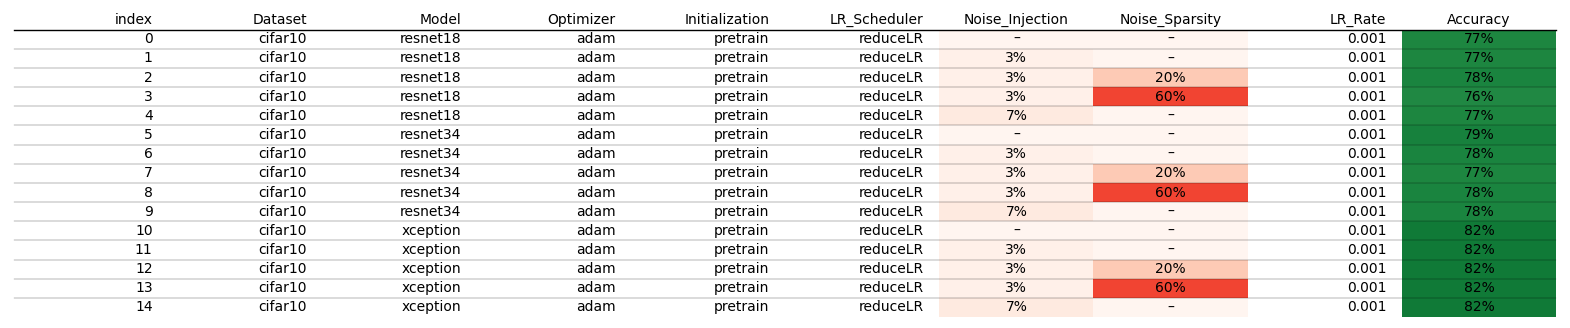

In [11]:
root = osp.join("/home/vision/Repo/cleanset/logs")

# Create a DataFrame to store the data
result = {
    'Dataset': [],
    'Model': [],
    'Optimizer': [],
    'Initialization': [],
    'LR_Scheduler': [],
    'Noise_Injection': [],
    'Noise_Sparsity': [],
    'LR_Rate': [],
    'Fold': [],
    'Accuracy': []
}


iterations_log = None
for dataset_name in all_datasets:
    train_transfm, val_transfm = transforms[dataset_name]
    test_dataset = GeneralDataset(dataset_name=dataset_name, label_column='true_label', phase=PHASE.test, transform=val_transfm) 
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=64,
        shuffle=False,
        collate_fn=collate_fns[dataset_name]
    )
    for model_name in all_models:
        for optim in all_optim:
            for initialization in all_initialization:
                for lr_scheduler in all_lr_scheduler:
                    for noise_injection in all_noise_injection:
                        for noise_sparsity in all_noise_sparsity:
                            for lr_rate in all_lr_rate:
                                for fold in all_folds:                                
                                    result['Dataset'].append(dataset_name)
                                    result['Model'].append(model_name)
                                    result['Optimizer'].append(optim)
                                    result['Initialization'].append(initialization)
                                    result['LR_Scheduler'].append(lr_scheduler)
                                    result['Noise_Injection'].append(noise_injection)
                                    result['Noise_Sparsity'].append(noise_sparsity)
                                    result['LR_Rate'].append(lr_rate)
                                    result['Fold'].append(fold)

                                    glob_regex = osp.join(root, dataset_name, model_name, optim, initialization, lr_scheduler, f"np={noise_injection}", f"ns={noise_sparsity}", f"lr={lr_rate}", fold, '*.pt')
                                    model_paths = sorted(glob.glob(glob_regex))
                                    if len(model_paths) == 0:
                                        result['Accuracy'].append(None)
                                    else:
                                        model = models[model_name](num_classes=len(dataset_configs[dataset_name].classes))
                                        try:
                                            model.load_state_dict(torch.load(model_paths[0]))
                                        except:
                                            if model_name == 'resnet34':
                                                model.load_state_dict(
                                                    remove_prefix_from_state_dict(
                                                        torch.load(model_paths[0])
                                                        , f'{"resnet34"}.'
                                                        )
                                                    )
                                            else:
                                                model.load_state_dict(
                                                    remove_prefix_from_state_dict(
                                                        torch.load(model_paths[0])
                                                        , f'{model_name}.'
                                                        )
                                                    )


                                        model.to(device)
                                        all_labels = []
                                        all_predictions = []
                                        with torch.no_grad():
                                            validation_epoch_loss = []
                                            model.eval()
                                            iteration = 0
                                            for idx, data, labels in test_loader:
                                                data, labels = data.to(device), labels.to(device)
                                                prediction_values = model(data)  # (B, C)
                                                prediction_probs = softmax(prediction_values, dim=1)  # (B, C)


                                                all_labels.extend(torch.max(labels, 1)[1].cpu().numpy())
                                                all_predictions.extend(torch.max(prediction_probs, 1)[1].cpu().numpy())
                                       
                                        # Calculate overall accuracy
                                        overall_accuracy = accuracy_score(all_labels, all_predictions)
                                        result['Accuracy'].append(overall_accuracy)

df = pd.DataFrame(result)
df = df.dropna()
df = df.groupby(['Dataset', 'Model', 'Optimizer', 'Initialization', 'LR_Scheduler', 'Noise_Injection', 'Noise_Sparsity', 'LR_Rate'], as_index=False)['Accuracy'].mean()

df['Accuracy'] = df['Accuracy'].round(2)

# Extract 'Noise_Injection' and 'Noise_Sparsity' as float
df['Noise_Injection'] = df['Noise_Injection'].str.extract('(\d+\.\d+)').astype(float)
df['Noise_Sparsity'] = df['Noise_Sparsity'].str.extract('(\d+\.\d+)').astype(float)

# Init a figure 
fig, ax = plt.subplots(figsize=(20, 4))

# Create the Table() object
tab = Table(df, column_definitions=[
    ColumnDefinition(name="Accuracy", cmap=Greens, textprops={"ha": "center"}, formatter=decimal_to_percent),
    ColumnDefinition(name="Noise_Injection", cmap=Reds, textprops={"ha": "center"}, formatter=decimal_to_percent),
    ColumnDefinition(name="Noise_Sparsity", cmap=Reds, textprops={"ha": "center"}, formatter=decimal_to_percent)
])

# Display the output
plt.show()

## Get Best Acc for each noise settings

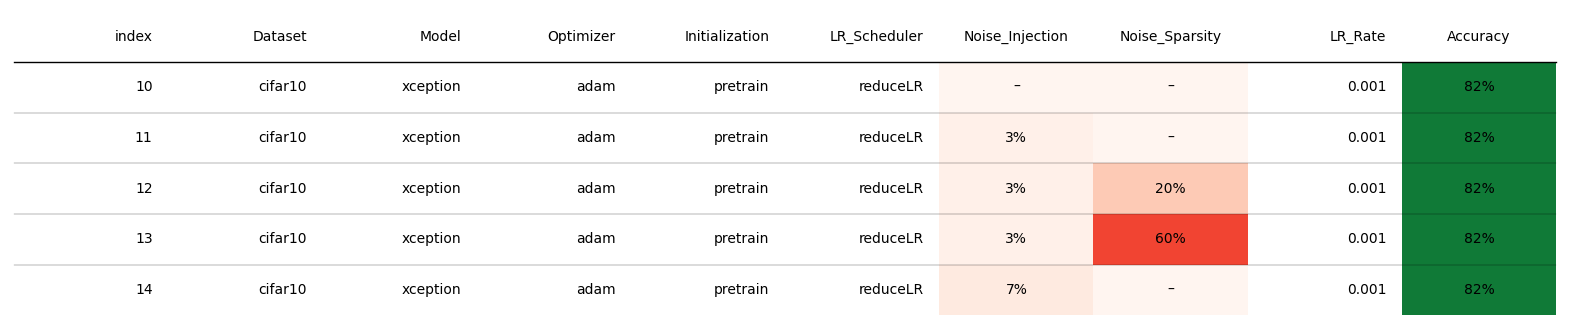

In [14]:
max_accuracy_rows = df.loc[df.groupby(['Noise_Injection', 'Noise_Sparsity'])['Accuracy'].idxmax()]


# Init a figure 
fig, ax = plt.subplots(figsize=(20, 4))

# Create the Table() object
tab = Table(max_accuracy_rows, column_definitions=[
    ColumnDefinition(name="Accuracy", cmap=Greens, textprops={"ha": "center"}, formatter=decimal_to_percent),
    ColumnDefinition(name="Noise_Injection", cmap=Reds, textprops={"ha": "center"}, formatter=decimal_to_percent),
    ColumnDefinition(name="Noise_Sparsity", cmap=Reds, textprops={"ha": "center"}, formatter=decimal_to_percent)
])

# Display the output
plt.show()